In [4]:
import uproot
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from collections import Counter

%matplotlib inline

In [5]:
def path_generator(t:str, eda=True) -> list:
    '''
    Approximately (size of 50 QCD dataset) == (size of 14 Hbb dataset)
    '''
    lst = []
    
    if t.upper() == 'QCD':
        main = '/home/isl017/teams/DSC180A_FA21_A00/a11/train_mass_qcd/\
QCD_HT{low}to{high}_TuneCP5_13TeV-madgraph-pythia8/'
        if eda:
            num_data = 10 
        
        bounds = [
            [1000,1500],
            [1500,2000],
            [2000, 'Inf'],
            [500,700],
            [700,1000]
        ]
        
        for bound in bounds:
            low, high = bound
            fp = main.format(low=low, high=high)
            all_files = os.listdir(fp)
            all_files_fp = [fp + f for f in all_files]
            samples = random.sample(all_files_fp, k=num_data)
            
            # There's this one hidden file under (700-1000) bound
            while '.nano_mc2017_174_Skim.root.ViGCYO' in samples:
                samples = random.sample(all_files_fp, k=num_data) # Re-sample

            lst += samples # In total, randomly generate filepaths to 50 different QCD .root files
    elif t.upper() == 'HBB':
        main = '/home/isl017/teams/DSC180A_FA21_A00/a11/train_mass_hbb/\
BulkGravitonToHHTo4Q_MX-600to6000_MH-15to250_part{}_TuneCP5_13TeV-madgraph_pythia8/'
        if eda:
            num_data = 4
            
        parts = [1,2]
        
        for part in parts:
            # Since files in Hbb directory1 are smaller than those in Hbb directory2, 
            # sample more from directory1 to balance size of samples generating from 
            # directory2
            # (11 .root files in dir1) == (3 .root files in dir2)
            
#             if part==1:
#                 num_data = 11
#             else:
#                 num_data = 3
                
            fp = main.format(part)
            all_files = os.listdir(fp)
            samples = random.sample(all_files, k=num_data)
            files = [os.path.join(fp, sample) for sample in samples]
            
            lst += files
    return lst

In [6]:
qcd_eda_sets = path_generator('QCD', eda=True)
hbb_eda_sets = path_generator('hbb', eda=True)

In [36]:
def load_jet_features(fps):
    '''
    For all files at defined filepaths,
    extract jet features from each of them as well as their type
    '''
    jet_features = []
    unnecesssary_attrs = [
        'fj_idx',
#         'fj_genRes_mass',
        'fj_lsf3'
    ]
    df = pd.DataFrame()
    
    for i in range(len(fps)):
        path = fps[i]
        f = uproot.open(path)
        tree = f['Events']
        
        if i==0:
            attrs = [branch.name for branch in tree.branches]
            jet_features += list(filter(lambda x:x.startswith('fj'), attrs))
            jet_features = [feat for feat in jet_features if feat not in unnecesssary_attrs] # drop sterile attributes
        
        features = tree.arrays(jet_features, library='np')
        df = pd.concat([df, pd.DataFrame(features)], axis=0)
        
    df = df.reset_index(drop=True)
    
    return df

-------

#### Validating the labels of QCD/signal jet samples

In [37]:
df_qcd = load_jet_features(qcd_eda_sets)
display(df_qcd.head())
print('\n', f'{df_qcd.shape[0]} randomly generated QCD jet samples')

,fj_pt,fj_eta,fj_phi,fj_mass,fj_msoftdrop,fj_deepTagMD_H4qvsQCD,fj_deepTag_HvsQCD,fj_PN_H4qvsQCD,fj_PN_XbbvsQCD,fj_genjetmsd,...,fj_genW_decay,fj_genWstar_decay,fj_evt_met_covxx,fj_evt_met_covxy,fj_evt_met_covyy,fj_evt_met_dphi,fj_evt_met_pt,fj_evt_met_sig,fj_evt_pupmet_pt,fj_evt_pupmet_dphi
0,646.5,-1.124756,-1.499512,138.625,68.125000,-1000.0,-1000.0,0.018214,0.006513,66.437500,...,-99.0,-99.0,632.0,-194.5,3744.0,2.137207,26.212317,0.833984,9.001931,-2.593732
1,626.0,-0.533936,1.688965,90.625,5.902344,-1000.0,-1000.0,0.000016,0.032026,6.332031,...,-99.0,-99.0,632.0,-194.5,3744.0,-1.051270,26.212317,0.833984,9.001931,0.500977
2,551.0,0.294495,2.602051,109.375,41.906250,-1000.0,-1000.0,0.001407,0.015043,47.062500,...,-99.0,-99.0,1892.0,-710.0,994.0,2.467756,27.493767,0.722656,51.226021,-3.040405
3,500.5,-0.249359,-0.536987,120.000,7.453125,-1000.0,-1000.0,0.001143,0.003213,9.320312,...,-99.0,-99.0,1892.0,-710.0,994.0,-0.676392,27.493767,0.722656,51.226021,0.098633
4,593.0,0.107239,1.342285,213.250,4.644531,-1000.0,-1000.0,0.000015,0.000954,5.019531,...,-99.0,-99.0,904.0,412.0,3008.0,1.240234,50.732494,2.812500,96.839462,0.330322



 375309 randomly generated QCD jet samples


In [38]:
df_signal = load_jet_features(hbb_eda_sets)
display(df_signal.head())
print('\n', f'{df_signal.shape[0]} randomly generated signal jet samples')

,fj_pt,fj_eta,fj_phi,fj_mass,fj_msoftdrop,fj_deepTagMD_H4qvsQCD,fj_deepTag_HvsQCD,fj_PN_H4qvsQCD,fj_PN_XbbvsQCD,fj_genjetmsd,...,fj_genW_decay,fj_genWstar_decay,fj_evt_met_covxx,fj_evt_met_covxy,fj_evt_met_covyy,fj_evt_met_dphi,fj_evt_met_pt,fj_evt_met_sig,fj_evt_pupmet_pt,fj_evt_pupmet_dphi
0,2210.0,0.206207,-1.231445,171.375,167.125000,-1000.0,-1000.0,2.374396e-08,1.000000,170.125000,...,-99.0,-99.0,3640.0,-4672.0,14528.0,2.474121,54.314430,0.725098,540.261658,-3.105451
1,1638.0,-0.406128,1.930420,189.625,34.812500,-1000.0,-1000.0,2.017337e-03,0.999859,5.621094,...,-99.0,-99.0,3640.0,-4672.0,14528.0,-0.687744,54.314430,0.725098,540.261658,0.015869
2,2140.0,0.925171,1.492920,215.750,174.375000,-1000.0,-1000.0,1.124971e-03,0.997242,166.625000,...,-99.0,-99.0,1880.0,0.0,1880.0,-3.116943,68.855728,2.519531,234.250366,2.999250
3,1911.0,0.029846,-1.627197,376.750,156.375000,-1000.0,-1000.0,2.141329e-04,0.999994,170.750000,...,-99.0,-99.0,1880.0,0.0,1880.0,0.003174,68.855728,2.519531,234.250366,-0.163818
4,2308.0,0.410583,2.212891,478.000,0.000031,-1000.0,-1000.0,3.774518e-01,0.104241,1.295898,...,-99.0,-99.0,1916.0,-94.5,2056.0,-3.121216,284.556122,38.656250,278.727966,3.137677



 653478 randomly generated signal jet samples


#### Data validation

Validate the type of jets in our samples; each jet should only be associated to one unique type of QCD/signal

In [39]:
# QCD
# For this checkup, we only need label attribute

IS_QCDb = 'fj_isQCDb'
IS_QCDothers = 'fj_isQCDothers'
all_attrs = df_qcd.columns.tolist()
start_idx = all_attrs.index(IS_QCDb)
end_idx = all_attrs.index(IS_QCDothers)+1

qcd_labels = all_attrs[start_idx:end_idx]

In [40]:
df_qcd_labels = df_qcd[qcd_labels]
display(df_qcd_labels.head())

,fj_isQCDb,fj_isQCDbb,fj_isQCDc,fj_isQCDcc,fj_isQCDlep,fj_isQCDothers
0,0,0,0,0,0,1
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


In [41]:
# We want each jet corresponding to exactly one type

print(f'Each jet corresponds to exactly one type:\
 {len(df_qcd_labels.sum(axis=1).unique()) == 1}')

Each jet corresponds to exactly one type: True


In [42]:
# How many jets are there for different QCD types?

display(df_qcd_labels.sum(axis=0).sort_values(ascending=False).to_frame(name='Count'))

,Count
fj_isQCDothers,228630
fj_isQCDlep,81521
fj_isQCDc,26249
fj_isQCDcc,26218
fj_isQCDb,6410
fj_isQCDbb,6281


In [43]:
# Signal jets
# For this checkup, we only need label attribute

IS_HBB = 'fj_H_bb'
IS_HQQ = 'fj_H_qq'
all_attrs = df_signal.columns.tolist()
start_idx = all_attrs.index(IS_HBB)
end_idx = all_attrs.index(IS_HQQ)+1

signal_labels = all_attrs[start_idx:end_idx]

In [44]:
df_signal_labels = df_signal[signal_labels]

# We're only going to include signal jets
# of types H_bb, H_cc, H_qq for performing EDA
df_signal_labels = df_signal_labels[
    (df_signal_labels['fj_H_bb'] == 1) |
    (df_signal_labels['fj_H_cc'] == 1) |
    (df_signal_labels['fj_H_qq'] == 1)
]

# Drop observations that are associated to more than single type
df_signal_labels['temp'] = df_signal_labels['fj_H_bb'] + df_signal_labels['fj_H_cc'] + df_signal_labels['fj_H_qq']
print(f'Before filtering: {df_signal_labels.shape[0]} rows', '\n')

df_signal_labels = df_signal_labels[df_signal_labels['temp'] == 1].drop(columns='temp')
print(f'After filtering: {df_signal_labels.shape[0]} rows')

Before filtering: 617370 rows 

After filtering: 617314 rows


In [45]:
# We want each jet corresponding to exactly one type

print(f'Each jet corresponds to exactly one type:\
 {len(df_signal_labels.sum(axis=1).unique()) == 1}')

Each jet corresponds to exactly one type: True


In [46]:
# How many jets are there for each signal type?

display(df_signal_labels.sum(axis=0).sort_values(ascending=False).to_frame(name='Count'))

,Count
fj_H_bb,206071
fj_H_cc,205974
fj_H_qq,205269


------

#### EDA \#1

 Plot distribution of our target attribute(`fj_genjetmsd`), generator-level soft drop mass, of QCD jets according to their type

In [47]:
# Filtering using the validation results

signal_idx = df_signal_labels.index.tolist()
df_signal = df_signal.filter(items=signal_idx, axis=0)

In [48]:
# Create temporary `class` label to differentiate QCD jets from signal jets
# Then concatenate QCD dataset to signal dataset

df_qcd['Type'] = 'QCD'
df_signal['Type'] = 'Signal'

df_qcd_and_signal = pd.concat([df_qcd, df_signal], axis=0)
display(df_qcd_and_signal.head())

,fj_pt,fj_eta,fj_phi,fj_mass,fj_msoftdrop,fj_deepTagMD_H4qvsQCD,fj_deepTag_HvsQCD,fj_PN_H4qvsQCD,fj_PN_XbbvsQCD,fj_genjetmsd,...,fj_genWstar_decay,fj_evt_met_covxx,fj_evt_met_covxy,fj_evt_met_covyy,fj_evt_met_dphi,fj_evt_met_pt,fj_evt_met_sig,fj_evt_pupmet_pt,fj_evt_pupmet_dphi,Type
0,646.5,-1.124756,-1.499512,138.625,68.125000,-1000.0,-1000.0,0.018214,0.006513,66.437500,...,-99.0,632.0,-194.5,3744.0,2.137207,26.212317,0.833984,9.001931,-2.593732,QCD
1,626.0,-0.533936,1.688965,90.625,5.902344,-1000.0,-1000.0,0.000016,0.032026,6.332031,...,-99.0,632.0,-194.5,3744.0,-1.051270,26.212317,0.833984,9.001931,0.500977,QCD
2,551.0,0.294495,2.602051,109.375,41.906250,-1000.0,-1000.0,0.001407,0.015043,47.062500,...,-99.0,1892.0,-710.0,994.0,2.467756,27.493767,0.722656,51.226021,-3.040405,QCD
3,500.5,-0.249359,-0.536987,120.000,7.453125,-1000.0,-1000.0,0.001143,0.003213,9.320312,...,-99.0,1892.0,-710.0,994.0,-0.676392,27.493767,0.722656,51.226021,0.098633,QCD
4,593.0,0.107239,1.342285,213.250,4.644531,-1000.0,-1000.0,0.000015,0.000954,5.019531,...,-99.0,904.0,412.0,3008.0,1.240234,50.732494,2.812500,96.839462,0.330322,QCD


In [49]:
df_qcd_and_signal['Type'].value_counts()

Signal    617314
QCD       375309
Name: Type, dtype: int64

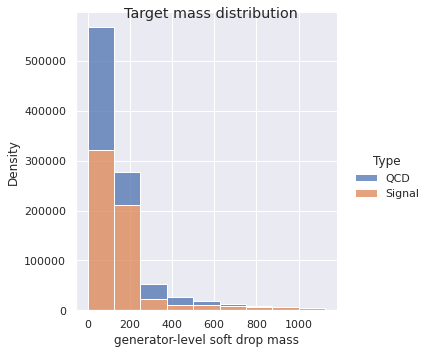

In [50]:
# Used `.displot()` from seaborn for visualization

ax = sns.displot(x='fj_genjetmsd', data=df_qcd_and_signal, hue='Type',
                bins=range(0, 1250, 125), multiple='stack')

ax.set_axis_labels('generator-level soft drop mass', 'Density');
ax.fig.suptitle('Target mass distribution');

-------

In [25]:
# BELOW COULD BE USED FOR VALIDATION OF signal jets DATASET

# Hbb jets are known to be the most common type of 
# jet that contains Higgs boson
# This is because Higgs boson is more likely to decay into
# *exactly* two b-quarks in a single proton-proton event
# These b quarks are known for their relatively heavier weights
# compared to other elementary particles
# which gives them longer lifespan 
# One conspicuous characteristic of Hbb jets
# is hence their long lifespan
# which is enabled by heavy weights of Higgs boson and its decay product, b quarks
# Let's now explore if this finding holds in our datset
# using `fj_genjetmsd` attribute

# Does above trend hold for QCD jets also?
# i.e. Do certain types of QCD jet tend to be heavier than otehr types?

### EDA \#2 -- QCD

 Does presence of secondary vertices in a jet have any effect on jet mass?

In [51]:
def load_num_sv(fps):
    '''
    For all files at defined filepaths,
    extract secondary vertex features from 
    each of the file
    '''
    NUMPY = 'np'
    SV_PT_LOG = 'sv_pt_log'
    FJ_GENJETMSD = 'fj_genjetmsd'
    num_svs = []
    jet_mass = []
    
    for i in range(len(fps)):
        path = fps[i]
        f = uproot.open(path)
        tree = f['Events']
        sv_pt_logs = tree.arrays(SV_PT_LOG, library=NUMPY)[SV_PT_LOG]
        num_sv = list(map(lambda sublst: len(list(filter(lambda x: x != 0, sublst))), sv_pt_logs))
        num_svs += num_sv
        
        # Jet masses(target)
        masses = tree.arrays(FJ_GENJETMSD, library=NUMPY)[FJ_GENJETMSD].tolist()
        jet_mass += masses
        
#     df = df.reset_index(drop=True)
    
    return num_svs, jet_mass

In [52]:
# QCD

qcd_num_svs, qcd_jet_mass = load_num_sv(qcd_eda_sets)

avg_qcd_num_svs = np.mean(qcd_num_svs)
avg_qcd_jet_mass = np.mean(qcd_jet_mass)

med_qcd_num_svs = np.median(qcd_num_svs)
med_qcd_jet_mass = np.median(qcd_jet_mass)

qcd_num_svs_counter = Counter(qcd_num_svs)
temp = qcd_num_svs_counter.items()
qcd_num_svs_counts = sorted(temp, reverse=True, key=lambda x:x[1])
# Later create 2 x 2 dataframe; indexing QCD and Signal, columns of mean, median

In [53]:
df_qcd_num_svs_counts = pd.DataFrame(qcd_num_svs_counts,
                                     columns=['# of SVs in a jet', 'counts'],
                                    ).set_index('# of SVs in a jet')

display(df_qcd_num_svs_counts)
print(f'Majority of QCD jets in our data has no to only few secondary vertex\
 recorded', '\n')

,counts
# of SVs in a jet,
0,136542
1,121482
2,66696
3,29837
4,12521
5,5003
6,1967
7,1261


Majority of QCD jets in our data has no to only few secondary vertex recorded 



In [54]:
qcd_dict = {
    '# of SVs recorded':qcd_num_svs,
    'generator-level soft drop mass':qcd_jet_mass
}

qcd_df = pd.DataFrame(qcd_dict)
display(qcd_df.head())

,# of SVs recorded,generator-level soft drop mass
0,0,66.437500
1,1,6.332031
2,2,47.062500
3,1,9.320312
4,0,5.019531


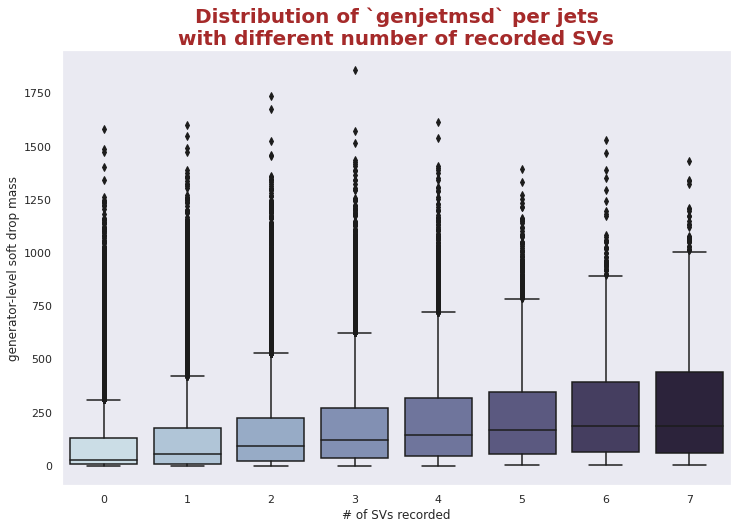

In [55]:
# Boxplot to show relationship between them

_ = sns.set(rc={'figure.figsize':(12,8)})

qcd_box = sns.boxplot(x='# of SVs recorded',
           y='generator-level soft drop mass',
           data=qcd_df, palette='ch:s=.25,rot=-.25')

_ = qcd_box.grid(False)
TITLE = 'Distribution of `genjetmsd` per jets\nwith different number of recorded SVs'
_ = qcd_box.set_title(TITLE, fontdict={'size':20, 'weight':'bold', 'color':'brown'})

-----

### EDA\#3 Transverse Momentum, Pseudorapidity, and Jet Mass

Here, we will utilize LM plots to uncover if Transverse Momentum and Pseduorapidity have any correlation with Jet Mass. Our hypothesis is: because a high transverse momentum can indicate a hard collision, it may be possible that a larger jet mass may result from larger transverse momentum. Similarly, higher pseudorapidity, which higher values indicate more perpendicular angles from the beam, may suggest higher jet mess. 

In [68]:
# Only need subset of attributes for this part of EDA
# Maximize memory(space) efficiency

eda1_attrs = [
    'fj_pt',
    'fj_msoftdrop',
    'fj_genRes_mass',
    'fj_eta',
    'fj_genjetmsd'
]

df_qcd_eda1 = df_qcd[eda1_attrs]

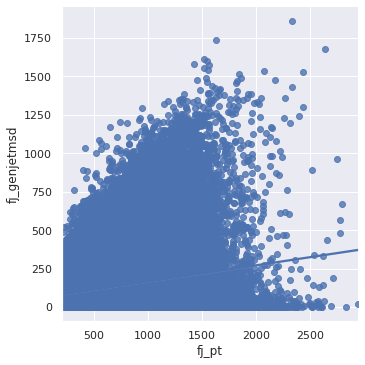

In [67]:
sns.lmplot(x="fj_pt", y="fj_genjetmsd", data=df_qcd_eda1)
plt.show()

The transverse momentum and mass plot indicates a slight positive correlation. However, due to the largeness and spread of the data, it is hard to confidently conclude the robustness of this correlation. 

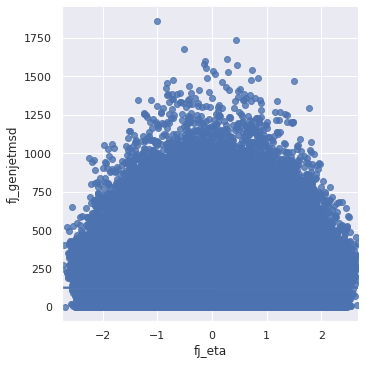

In [70]:
sns.lmplot(x="fj_eta", y="fj_genjetmsd", data=df_qcd_eda1)
plt.show()

For our second plot (pseudorapidity and mass), we see a distribution with the largest values of mass centering around 0 pseudorapidity. This goes against our hypothesis and shows that there is in fact no linear correlation. However, it suggests that fj_eta values closer to 0 have higher jet mass. 